In [1]:
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot as py
%matplotlib inline

In [2]:
filepath = os.path.join('geminism.dat')
with open(filepath, 'r') as infile:
    x, y = np.loadtxt(infile, dtype=float, unpack=True)
    
filepathe = os.path.join('gemini_experimental.csv')
with open(filepathe, 'r') as infile:
    Alpha_exp, CL_exp = np.loadtxt(infile, dtype=float, delimiter=',', unpack=True)

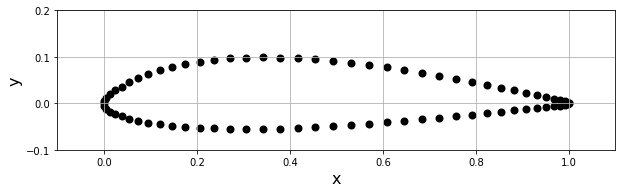

In [3]:
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.scatter(x, y, color='k', linewidth=2)
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.1)
py.ylim(-0.1, 0.2);

In [4]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)
        
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
            
        if self.beta <= np.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
            
        self.sigma = 0.0
        self.vt = 0.0
        self.cp = 0.0

In [5]:
N = 78
panels = np.empty(N, dtype=object)
for i in range(N):
    panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])

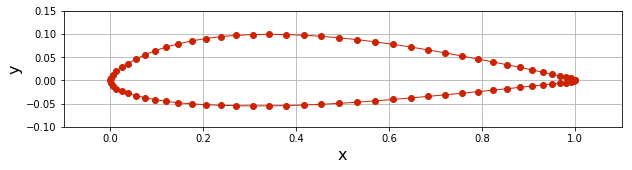

In [6]:
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.1)
py.ylim(-0.1, 0.15);

In [7]:
class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)

def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 + 
                 (y - (panel.ya + np.cos(panel.beta) * s))**2))
    return integrate.quad(integrand, 0.0, panel.length)[0]

def source_contribution_normal(panels):
    A = np.empty((panels.size, panels.size), dtype=float)
    np.fill_diagonal(A, 0.5)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 np.cos(panel_i.beta),
                                                 np.sin(panel_i.beta))
    return A

def vortex_contribution_normal(panels):
    A = np.empty((panels.size, panels.size), dtype=float)
    np.fill_diagonal(A, 0.0)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc,
                                                  panel_j,
                                                  np.sin(panel_i.beta),
                                                  -np.cos(panel_i.beta))
    return A

def kutta_condition(A_source, B_vortex):
    b = np.empty(A_source.shape[0] + 1, dtype=float)
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    b[-1] = -np.sum(A_source[0,:] + A_source[-1,:])
    return b

def build_singularity_matrix(A_source, B_vortex):
    A = np.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype = float)
    A[:-1, :-1] = A_source
    A[:-1, -1] = np.sum(B_vortex, axis=1)
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

def build_rhs_vector(panels, freestream, un=0.0):
    b = np.empty(panels.size + 1, dtype=float)
    b[:-1] += un
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    b[-1] = -freestream.u_inf * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[-1].beta))
    return b

def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    A = np.empty((panels.size, panels.size + 1), dtype=float)
    A[:, :-1] = B_vortex
    A[:, -1] = -np.sum(A_source, axis=1)
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta
                                   for panel in panels])
    strengths = np.append([panel.sigma for panel in panels], gamma)
    tangential_velocities = np.dot(A, strengths) + b
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        
def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2


In [8]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(A_source, B_vortex)

In [9]:
N_alpha = 10
alpha = np.linspace(-6.0, 12.0, N_alpha)
p_inf = 101325.0 #Pascals
rho = 1.225 #kg/m^3
Re = 300000.0
chord = x.max() - x.min()
mu = 1.73 * 10**(-5) #Ns/m^2
u_inf = mu * Re / (rho * chord)

In [10]:
def Lift(N, panels, freestream, p_inf, rho):
    p = np.empty(N, dtype=float)
    beta = np.empty(N, dtype=float)
    length =np.empty(N, dtype=float)
    for j in range(N):
        p[j] = p_inf + ((1/2) *  panels[j].cp * rho * freestream.u_inf**2)
        beta[j] = panels[j].beta
        length[j] = panels[j].length
    
    Lift = -np.sum(p * np.sin(beta)* length)
    return Lift

In [11]:
def CL_varying_angles(N_alpha, N, u_inf, alpha, panels, A, A_source, B_vortex, p_inf, rho, chord, un):
    L = np.empty(N_alpha, dtype=float)
    cp = np.empty((N, N_alpha), dtype=float)
    ut = np.empty((N, N_alpha), dtype=float)
    for i in range(N_alpha):
        freestream = Freestream(u_inf, alpha[i])
        b = build_rhs_vector(panels, freestream, un=un)
        strengths = np.linalg.solve(A, b)
        for k, panel in enumerate(panels):
            panel.sigma = strengths[k]
        gamma = strengths[-1]
        compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
        compute_pressure_coefficient(panels, freestream)
        for n, panel in enumerate(panels):
            cp[n,i] = panel.cp
            ut[n,i] = panel.vt
        L[i] = Lift(N, panels, freestream, p_inf, rho)
    C_L = L / (0.5 * rho * u_inf**2 * chord)
    return C_L, cp, ut

In [12]:
C_L, cp, ut = CL_varying_angles(N_alpha, N, u_inf, alpha, panels, A, A_source, B_vortex, p_inf, rho, chord, un=0.0)

In [13]:
cpmin = np.empty(N_alpha, dtype=float)
idx_cpmin = np.empty(N_alpha, dtype=float)
for i in range(N_alpha):
    cpmin[i] = np.min(cp[:,i])
    idx_cpmin[i] = np.argmin(cp[:,i])
    
print(cpmin)
print(idx_cpmin)

[-2.75822768 -1.59679054 -0.73325764 -0.7112646  -0.93504483 -1.21134087
 -1.82569885 -3.2633758  -5.3582601  -7.95323729]
[40. 41. 42. 25. 27. 29. 37. 37. 38. 38.]


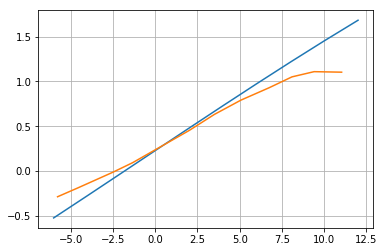

In [14]:
py.plot(alpha, C_L)
py.plot(Alpha_exp, CL_exp)
py.grid();

In [15]:
#boundary layer stuff

In [16]:
def solve_panel_method(panels, A_source, B_source, freestream, un=0.0):
    # Assemble the system.
    A = build_singularity_matrix(A_source, B_source)
    b = build_rhs_vector(panels, freestream, un=un)
    
    # Solve the system for the singularity strengths.
    strengths = np.linalg.solve(A, b)

    # Store the source-sheet strengths and the vortex-sheet strength.
    sigmas = strengths[:-1]
    gamma = strengths[-1]
    
    # Compute the tangential velocity component on the panels.
    bt =  freestream.u_inf * np.sin([freestream.alpha - p.beta for p in panels])
    ut = bt + np.dot(B_source, sigmas) - np.sum(A_source, axis=1) * gamma
    
    # Compute the pressure coefficient on the panels.
    cp = 1 - (ut / freestream.u_inf)**2
    
    return ut, cp

In [17]:
def running_coordinates(panels):
    ds = [0.0, 0.5 * panels[0].length]
    for i in range(len(panels) - 1):
        ds.append(0.5 * (panels[i].length + panels[i + 1].length))
    s = np.cumsum(ds)
    return s

In [18]:
def momentum_thickness(s, Ue, rho, mu):
    theta = np.empty_like(Ue)
    dUeds = np.gradient(Ue, s)
    theta[0] = np.sqrt(0.075 * mu / (rho * dUeds[0]))
    coeff = theta[0]**2 * Ue[0]**6
    for i in range(1, s.size):
        var = (coeff + 0.45 * mu / rho *
               np.trapz(Ue[:i + 1]**5, s[:i + 1]))
        theta[i] = np.sqrt(var / Ue[i]**6)
    return theta

def lambda_parameter(s, Ue, theta, rho, mu):
    dUeds = np.gradient(Ue, s)
    lamb = rho / mu * theta**2 * dUeds
    return lamb

def l_parameter(lamb):
    if lamb > 0.0:
        return 0.22 + 1.57 * lamb - 1.8 * lamb**2
    return 0.22 + 1.402 * lamb + 0.018 * lamb / (lamb + 0.107)

def shape_factor(lamb):
    if lamb > 0.0:
        return 2.61 - 3.75 * lamb + 5.24 * lamb**2
    return 2.088 + 0.0731 / (lamb + 0.14)

l_parameter_vec = np.vectorize(l_parameter)
shape_factor_vec = np.vectorize(shape_factor)

def skin_friction_coefficient(Ue, theta, lamb, rho, mu):
    Re_theta = rho * Ue * theta / mu
    cf = 2 * l_parameter_vec(lamb) / Re_theta
    return cf

def thwaites(s, Ue, rho, mu):
    theta = momentum_thickness(s, Ue, rho, mu)
    lamb = lambda_parameter(s, Ue, theta, rho, mu)
    H = shape_factor_vec(lamb)
    cf = skin_friction_coefficient(Ue, theta, lamb, rho, mu)
    return theta, H, cf

In [19]:
panelsb = np.empty(N, dtype=object)
for i in range(N):
    panelsb[i] = Panel(x[i], y[i], x[i+1], y[i+1])
freestream = Freestream(u_inf, 4.0)
uti, cpi = solve_panel_method(panels, A_source, B_vortex, freestream, 0.0)

In [20]:
utvis = np.empty((N,N_alpha), dtype=float)
cpvis = np.empty((N,N_alpha), dtype=float)
C_L_vis = np.empty(N_alpha, dtype=float)
for i in range(N_alpha):
    freestream = Freestream(u_inf, alpha[i])
    uti, cpi = solve_panel_method(panels, A_source, B_vortex, freestream, 0.0)
    idx = np.where(uti >= 0.0)[0][0]
    x_stagn, y_stagn = panels[idx].xa, panels[idx].ya
    upper = panels[idx - 1::-1]
    lower = panels[idx:]
    s_upper = running_coordinates(upper)
    s_lower = running_coordinates(lower)
    Ue_upper = np.empty(len(upper) + 1)
    Ue_upper[0] = 1e-6
    Ue_upper[1:] = -uti[idx - 1::-1]
    Ue_lower = np.empty(len(lower) + 1)
    Ue_lower[0] = 1e-6
    Ue_lower[1:] = uti[idx:]
    theta, H, cf = thwaites(s_upper, Ue_upper, rho, mu)
    delta = theta * H  # displacement thickness
    un_upper = np.gradient(Ue_upper * delta, s_upper)
    theta, H, cf = thwaites(s_lower, Ue_lower, rho, mu)
    delta = theta * H  # displacement thickness
    un_lower = np.gradient(Ue_lower * delta, s_lower)
    un = np.concatenate((un_upper[:0:-1], un_lower[1:]))
    utvis[:,i], cpvis[:,i] = solve_panel_method(panels, A_source, B_vortex, freestream, un=un)
    p = p_inf + 0.25 * cpvis[:,i] * rho * freestream.u_inf**2
    beta = np.empty(N, dtype=float)
    length =np.empty(N, dtype=float)
    for j in range(N):
        beta[j] = panels[j].beta
        length[j] = panels[j].length
    Lift = -np.sum(p * np.sin(beta)* length)
    C_L_vis[i] = Lift / (0.5 * rho * u_inf**2 * chord)

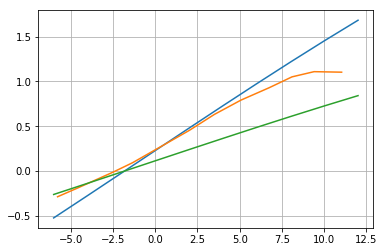

In [21]:
py.plot(alpha, C_L)
py.plot(Alpha_exp, CL_exp)
py.plot(alpha, C_L_vis)
py.grid();

In [70]:
freestream = Freestream(u_inf, 0.0)
ut, cp = solve_panel_method(panels, A_source, B_vortex, freestream, 0.0)
idx = np.where(uti >= 0.0)[0][0]
x_stagn, y_stagn = panels[idx].xa, panels[idx].ya
upper = panels[idx - 1::-1]
lower = panels[idx:]
s_upper = running_coordinates(upper)
s_lower = running_coordinates(lower)
cp_upper = cp[idx - 1::-1]
cp_lower = cp[idx:]

s_upper_laminar = s_upper[:cp_upper.argmin()]
s_upper_turbulent = s_upper[cp_upper.argmin():]

s_lower_laminar = s_lower[:cp_lower.argmin()]
s_lower_turbulent = s_lower[cp_lower.argmin():]

Ue_upper = np.empty(len(upper) + 1)
Ue_upper[0] = 1e-6
Ue_upper[1:] = -uti[idx - 1::-1]
Ue_lower = np.empty(len(lower) + 1)
Ue_lower[0] = 1e-6
Ue_lower[1:] = uti[idx:]
theta, H, cf = thwaites(s_upper_laminar, Ue_upper, rho, mu)
delta = theta * H  # displacement thickness
un_upper_laminar = np.gradient(Ue_upper * delta, s_upper)
theta, H, cf = thwaites(s_lower_laminar, Ue_lower, rho, mu)
delta = theta * H  # displacement thickness
un_lower_laminar = np.gradient(Ue_lower * delta, s_lower)

ValueError: when 1d, distances must match the length of the corresponding dimension